# **Age Prediction Based on User Information**

## **Intro**
*The task is to predict the age of users based on their access behaviour*

## **Preparing**
*Loading colab and libraries*

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount= True)

In [0]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks/Age Prediction')

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## **Data Exploration**

In [0]:
data = pd.read_csv('data.csv')

*Dropping the default index since DataFrames have their own index*

In [0]:
data.drop(columns= ['Unnamed: 0'], axis=1, inplace= True)

*Dropping duplicated values. The values getting dropped are those values that every feature in that row is repeated. This means, even if there is the same user uses different features, will make a meaningful row in the dataset. For example, a user having 60+ age but using Chrome or Chrome Mobile represents two different methods for the same age and therefore this row should be kept for analyses.*

In [0]:
data.drop_duplicates(keep = "first", inplace = True)
data.reset_index(drop=True, inplace=True)

*The user column is not needed for model training; therefore, it is dropped.*

In [0]:
data.drop(columns= ['user'], axis=1, inplace= True)

*Data consists of four feature columns including: Provider, Webpage, Browser, and City. The target is Age which is represented in 5 different age ranges. Each feature has different categories and all of the features are categorical features.*

In [8]:
data.describe()

,provider,age,webpage,browser,city
count,155160,155160,155160,155160,137827
unique,2,5,1194,37,8953
top,otto,30-39,www.fake-website-1.de,Chrome Mobile,berlin
freq,113647,47665,52379,42330,6161


*City is the only feature having 17333 null values. There are different strategies to treat the null values. In this particular case and in my opinion, not having value might have the meaning the user was not able to provide this information that can happen based on the age. Maybe a particular age group were not willing to share their city; therefore, these rows should not be dropped and have value. The null values are replaced with '-1' in order to treated as a category.*

In [0]:
data.city.isna().sum()

In [0]:
data.city.fillna("-1",inplace= True)

*Separating features from target*

In [0]:
data_y = pd.DataFrame(data['age'])
data_X = data.drop(['age'],axis=1)

*The data was just simply labeled without OneHotEncoding. The reason is that if OneHotEncoding would have been considered for this problem, the number of features could get out of hand for model and it may overfit or underfit.*

In [0]:
le = preprocessing.LabelEncoder()
data_y = data_y.apply(le.fit_transform)

In [0]:
le = preprocessing.LabelEncoder()
data_X = data_X.apply(le.fit_transform)

In [14]:
data_X.head()

,provider,webpage,browser,city
0,0,0,4,1786
1,1,306,3,208
2,0,417,15,0
3,1,0,15,0
4,0,528,11,0


# **Model Selection**
*Separating train and test from the data to train and test models.*

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=0)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

*Including, training, and comparing 7 different classifiers including the famous XGBoost model. It can be seen in the end that XGBoost is having the best accuracy. Even though the accuracy of the model is not convincing enough, in the last step, the hyper-parameter tuning of the model is explained.*

In [0]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),                          # Accept default parameters
    "Random Forest": RandomForestClassifier(),
    'Gradient Boosting Classifier':GradientBoostingClassifier(),
    'Adaptive Boosting Classifier':AdaBoostClassifier(),
    'Logistic Regression':LogisticRegression(),
    'K Nearest Neighbours':KNeighborsClassifier(8),
    'Gaussian Naive Bayes Classifier':GaussianNB(),
    'XGBoost': XGBClassifier()
}

In [0]:
import warnings
warnings.filterwarnings("ignore")

scores = list()

for clf in classifiers.values():
  clf.fit(X_train, y_train)
  scores.append(clf.score(X_test, y_test))

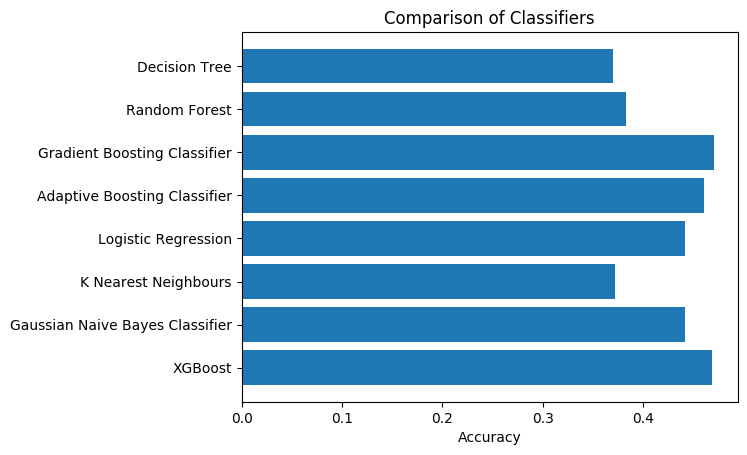

In [19]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(classifiers.keys()))

ax.barh(y_pos, scores, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classifiers.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Comparison of Classifiers')

plt.show()

*Best accuracy achieved is no more than 50 percent which is not promising and must be improved. The rest of the notebook discusses that something is missing to achieve better accuracy.*

# **Feature Analysis**
*The features can be seen not giving much information about the target. Since the target is distributed fairly between different classes of the features, the model cannot have better accuracy. Therefore, the analysis in here will investigate if the features be removed, what would happen to the model. In the end, it can be seen that these number of features are not sufficient enough and there is a need for other features correlating with the target.*

In [0]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [0]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator= clf, X= X_train, y= y_train, cv= 10)
accuracies.mean()

In [0]:
data_X_1 = data_X.drop(['provider'],axis=1)
data_X_2 = data_X.drop(['webpage'],axis=1)
data_X_3 = data_X.drop(['browser'],axis=1)
data_X_4 = data_X.drop(['city'],axis=1)

data_list = [data_X_1, data_X_2, data_X_3, data_X_4]
names= ['with all columns', 'without provider', 'without webpage', 'without browser', 'without city']
accuracies_i = list()
accuracies_i.append(accuracies.mean())

clf = RandomForestClassifier()

for data_i in data_list:
  X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(data_i, data_y, test_size=0.33, random_state=42)
  clf.fit(X_train_i, y_train_i)
  acc = clf.score(X_test_i, y_test_i)
  accuracies_i.append(acc)

accuracies_i

*It can be seen from the following graph, removing features from the model does not affect the model much and the model still needs more features to be added to have better predictions.*

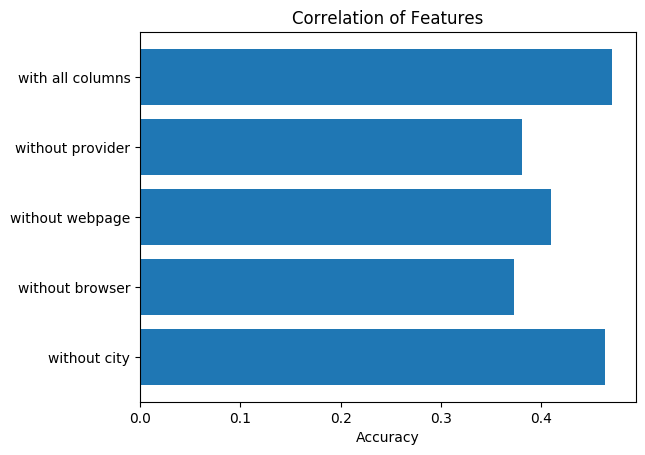

In [23]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(names))

ax.barh(y_pos, accuracies_i, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Correlation of Features')

plt.show()

# **Conclusion**
*It can be seen the model will poorly predict the age of users based on the given information. It can also be seen that model shows imrpovement with any additional information. Therefore, in order to improve the model, more information about the users is needed.*

# **Extra Step**
*The hyper-parameters of XGBoost model can be tuned in order to slightly imrpove the model. The following code uses Grid Search to improve the model.*

In [0]:
param_grid = {
  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
  "min_child_weight" : [ 1, 3, 5, 7 ],
  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
  }

In [0]:
from sklearn.model_selection import GridSearchCV

CV_rf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 10, scoring= 'accuracy', n_jobs= -1)
CV_rf.fit(X_train, y_train)

best_params = CV_rf.best_params_
print(CV_rf.best_params_)

best_accuracy = CV_rf.best_score_
print(CV_rf.best_params_)